# QRT ENS Data Challenge 2023 - Benchmark (english)

This notebook details the benchmark construction for the challenge - it may also help participants to start the competition.

## Libraries

In [289]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## Loading data

- `X_train` and `X_test` both have $35$ columns that represent the same explanatory variables but over different time periods. 

- `X_train` and `Y_train` share the same column `ID` - each row corresponds to a unique ID associated wwith a day and a country. 

- The target of this challenge `TARGET` in `Y_train` corresponds to the price change for daily futures contracts of 24H electricity baseload. 

- **You will notice some columns have missing values**.


In [290]:
# After downloading the X_train/X_test/Y_train .csv files in your working directory:

X_train = pd.read_csv('../X_train_NHkHMNU.csv')
Y_train = pd.read_csv('../y_train_ZAN5mwg.csv')
X_test = pd.read_csv('../X_test_final.csv')
X_test.shape

(654, 35)

## Model and train score

The benchark for this challenge consists in a simple linear regression, after a light cleaning of the data: The missing (NaN) values are simply filled with 0's and the `COUNTRY` column is dropped - namely we used the same model for France and Germany. 

In [291]:
lr = LinearRegression()

X_train_clean = X_train.drop(['COUNTRY'], axis=1).fillna(0)
Y_train_clean = Y_train['TARGET']

X_train_clean, X_val, y_train, y_val = train_test_split(X_train_clean, Y_train_clean, test_size=0.1, random_state=0)


lr.fit(X_train_clean, y_train)

output_train    = lr.predict(X_train_clean)
output_val      = lr.predict(X_val)
output_val_df = pd.DataFrame(lr.predict(X_val), index=X_val.index, columns=["prediction"])

def metric_train(output, y):

    return  spearmanr(output, y).correlation

print('Spearman correlation for the train set: {:.1f}%'.format(100 * metric_train(output_train, y_train) ))
print('Spearman correlation for the val   set: {:.1f}%'.format(100 * metric_train(output_val, y_val) ))
print(X_train_clean.shape)

Spearman correlation for the train set: 28.2%
Spearman correlation for the val   set: 20.3%
(1344, 34)


In [292]:
output_val_df.head()

,prediction
799,0.005157
1047,0.317522
1436,-0.567432
54,0.241009
793,0.319273


The Spearman correlation obtained with our model on the train data set is about 27.9%.

NB: Electricity price variations can be quite volatile and this is why we have chosen the Spearman rank correlation as a robust metric for the challenge, instead of the more standard Pearson correlation.

## Generate the benchmark output

Next, we process the test set the same way as we did on the train set and predict using our linear model, while saving the predictions to a csv file satisfying the challenge output contraints.


In [293]:
X_test_clean = X_test.drop(['COUNTRY'], axis=1).fillna(0)

Y_test_submission = X_test[['ID']].copy()
Y_test_submission['TARGET'] = lr.predict(X_test_clean)
Y_test_submission_origi = Y_test_submission.copy()

Y_test_submission.to_csv('benchmark_qrt.csv', index=False)

Y_test_submission.head()

,ID,TARGET
0,1115,-0.077957
1,1202,0.094718
2,1194,-0.280132
3,1084,-0.068293
4,1135,-0.005410


After submitting this benchmark_qrt.csv file at https://challengedata.ens.fr, we obtain a public score of around 15.9 % - this is the score to beat!


## Tips and ideas for improvements 

- Thinking about the fundamental price drivers of electricity in each country may be useful. 

- The dataset is small, so you will need to be careful not to overfit your models. It will be useful to use good crossvalidation practices. 


In [294]:
remove_collinearities = True
mutual_info_corr = False
Number_feature = 5
combine_features = True

In [295]:

def combine_feature_func(df):
    # --- 1. Rapporti e quote energetiche statiche ---
    df["DE_LOAD_RATIO"] = df["DE_RESIDUAL_LOAD"] / (df["DE_CONSUMPTION"] + 1e-6)
    df["FR_LOAD_RATIO"] = df["FR_RESIDUAL_LOAD"] / (df["FR_CONSUMPTION"] + 1e-6)
    df["DE_RENEW_SHARE"] = (df["DE_WINDPOW"] + df["DE_SOLAR"]) / (df["DE_CONSUMPTION"] + 1e-6)
    # df["DE_RENEW_TOT"] = df["DE_WINDPOW"] + df["DE_SOLAR"] + df["DE_HYDRO"]
    df["DE_RENEW_WO_HYDRO"] = df["DE_WINDPOW"] + df["DE_SOLAR"] 
    df["FR_RENEW_WO_HYDRO"] = df["FR_WINDPOW"] + df["FR_SOLAR"]
    df["FR_RENEW_TOT"] = df["FR_WINDPOW"] + df["FR_SOLAR"] + df["FR_HYDRO"] 

    df["DE_CONSUMPTION_RATIO"] = df["DE_CONSUMPTION"] / df["DE_RENEW_WO_HYDRO"]

    df["FR_RENEW_SHARE"] = (df["FR_WINDPOW"] + df["FR_SOLAR"]) / (df["FR_CONSUMPTION"] + 1e-6)
    df["FR_NUC_SHARE"] = df["FR_NUCLEAR"] / (df["FR_CONSUMPTION"] + 1e-6)
    df["EXCHANGE_BALANCE"] = df["DE_FR_EXCHANGE"] - df["FR_DE_EXCHANGE"]

    # --- 2. Differenze giornaliere (dinamiche temporali) ---
    diff_cols = ["DE_CONSUMPTION", "FR_CONSUMPTION", 
        "DE_RESIDUAL_LOAD", "FR_RESIDUAL_LOAD", 
        "DE_WINDPOW", "FR_WINDPOW", "DE_SOLAR", "FR_SOLAR",  
        "DE_NUCLEAR", "FR_NUCLEAR", 
        "DE_COAL", "FR_COAL", "DE_GAS", "FR_GAS", 
        "GAS_RET", "COAL_RET", "CARBON_RET", 
        "DE_FR_EXCHANGE", "FR_DE_EXCHANGE" ]

    for c in diff_cols:
        df[f"{c}_DIFF"] = df.groupby("COUNTRY")[c].diff() #* df[c]
        # df[f"{c}_DIFF_FR"] = df.groupby("COUNTRY")[c].diff() * df.groupby("COUNTRY")["DE_CONSUMPTION"]

    df["AA"] = df["CARBON_RET"] * df["FR_COAL"]**2
    df["BB"] = df["GAS_RET"] * df["FR_GAS"]**2

    # --- 3. Differenze relative (variazione percentuale) ---
    for c in diff_cols:
        df[f"{c}_RELDIFF"] = df[f"{c}_DIFF"] / (df[c].shift(1) + 1e-6)

    # --- 4. Spread e variazioni bilaterali ---
    df["TEMP_SPREAD"]        = df["DE_TEMP"]        - df["FR_TEMP"]
    df["LOAD_SPREAD"]        = df["DE_LOAD_RATIO"]  - df["FR_LOAD_RATIO"]
    df["RENEW_SPREAD"]       = df["DE_RENEW_SHARE"] - df["FR_RENEW_SHARE"]
    df["CONSUMPTION_SPREAD"] = df["DE_CONSUMPTION"] - df["FR_CONSUMPTION"]

    # --- 5. Costi marginali e variazioni nei costi ---
    df["DE_COST_GAS"]  = df["DE_GAS"]  * df["GAS_RET"]
    df["DE_COST_COAL"] = df["DE_COAL"] * df["COAL_RET"]
    df["FR_COST_GAS"]  = df["FR_GAS"]  * df["GAS_RET"]
    df["FR_COST_COAL"] = df["FR_COAL"] * df["COAL_RET"]
    df["DE_COST_LIGNITE"] = df["DE_LIGNITE"] * df["CARBON_RET"]
    for c in ["DE_COST_GAS", "DE_COST_COAL", "FR_COST_GAS", "FR_COST_COAL"]:
        df[f"{c}_DIFF"] = df.groupby("COUNTRY")[c].diff()

    # --- 6. Termini quadratici (non linearità dolci) ---
    df["CARBON_RET_SQ"] = df["CARBON_RET"]**2
    df["GAS_RET_SQ"]    = df["GAS_RET"]**2
    df["COAL_RET_SQ"]   = df["COAL_RET"] ** 2

    # --- 7. Interazioni di flusso e produzione ---
    df["FR_EXPORT_IMPACT"] = df["FR_NET_EXPORT"] * df["FR_NUCLEAR"]
    df["DE_EXPORT_IMPACT"] = df["DE_NET_EXPORT"] * df["DE_WINDPOW"]

    return df

In [296]:
from sklearn.feature_selection import mutual_info_regression
X_train = pd.read_csv('../X_train_NHkHMNU.csv')
X_test  = pd.read_csv('../X_test_final.csv')
Y_train = pd.read_csv('../y_train_ZAN5mwg.csv')

X_tot  = X_train.copy().fillna(0)

f_tot = X_tot.merge(Y_train,on=['ID'],how="left").fillna(0)

f_tot["benchmark"] = np.nan
f_tot.loc[output_val_df.index,"benchmark"] = output_val_df["prediction"]


if combine_features:
    f_tot = combine_feature_func(f_tot)
    X_test = combine_feature_func(X_test)

feat = {}
corr_df_tot = []
for country in ["DE","FR", "tot"]:
    mask = (f_tot["COUNTRY"] == country)
    if country == "tot":
        mask = ~mask

    corr_matrix = f_tot[mask].drop(columns=["COUNTRY","TARGET","benchmark"]).corr(method="spearman")
    # --- mutual information al posto di spearman ---
    if mutual_info_corr:
        X = f_tot[mask].drop(columns=["COUNTRY","TARGET","benchmark"]).fillna(0)
        y = f_tot[mask]["TARGET"]
        mi   = mutual_info_regression(X, y, random_state=0)
        corr = pd.Series(mi, index=X.columns)
    else:
        corr = f_tot[mask].drop(columns=["COUNTRY","TARGET","benchmark"]).corrwith(f_tot[mask]["TARGET"],method="spearman")


    corr_df = corr.to_frame(name="correlation").reset_index()
    corr_df["abs corr"] = np.abs(corr_df["correlation"])
    corr_df_tot.append(corr_df.sort_values(by="abs corr",ascending=False))

    if Number_feature<corr_df_tot[-1].iloc[:].shape[0]:
        feat[country] = list(corr_df_tot[-1].iloc[0:Number_feature]["index"])
    else:
        mask = (corr_df_tot[-1]["abs corr"] >= 0.02)
        feat[country] = list(corr_df_tot[-1][mask]["index"])
    print("____________________________")
    print(country)
    print(corr_df_tot[-1].iloc[0:10])
    print("____________________________")
    

Y_test_submission    = X_test[['ID']].copy();


____________________________
DE
                    index  correlation  abs corr
23       DE_RESIDUAL_LOAD     0.324335  0.324335
8           DE_NET_IMPORT     0.306204  0.306204
6           DE_NET_EXPORT    -0.306204  0.306204
20             DE_WINDPOW    -0.300933  0.300933
37      DE_RENEW_WO_HYDRO    -0.289337  0.289337
10                 DE_GAS     0.253410  0.253410
46  DE_RESIDUAL_LOAD_DIFF     0.245964  0.245964
48        DE_WINDPOW_DIFF    -0.244668  0.244668
14               DE_HYDRO     0.217900  0.217900
49        FR_WINDPOW_DIFF    -0.212243  0.212243
____________________________
____________________________
FR
                index  correlation  abs corr
33         CARBON_RET     0.191809  0.191809
63                 AA     0.176971  0.176971
31            GAS_RET     0.148956  0.148956
64                 BB     0.144423  0.144423
60    CARBON_RET_DIFF     0.128673  0.128673
21         FR_WINDPOW    -0.121530  0.121530
38  FR_RENEW_WO_HYDRO    -0.105737  0.105737
58      

In [297]:
(X_train.columns)

Index(['ID', 'DAY_ID', 'COUNTRY', 'DE_CONSUMPTION', 'FR_CONSUMPTION',
       'DE_FR_EXCHANGE', 'FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT',
       'DE_NET_IMPORT', 'FR_NET_IMPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL',
       'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR',
       'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE',
       'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND',
       'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET'],
      dtype='object')

In [298]:
corr_df_tot[0].head(20)

,index,correlation,abs corr
23,DE_RESIDUAL_LOAD,0.324335,0.324335
8,DE_NET_IMPORT,0.306204,0.306204
6,DE_NET_EXPORT,-0.306204,0.306204
20,DE_WINDPOW,-0.300933,0.300933
37,DE_RENEW_WO_HYDRO,-0.289337,0.289337
10,DE_GAS,0.253410,0.253410
46,DE_RESIDUAL_LOAD_DIFF,0.245964,0.245964
48,DE_WINDPOW_DIFF,-0.244668,0.244668
14,DE_HYDRO,0.217900,0.217900
49,FR_WINDPOW_DIFF,-0.212243,0.212243


In [299]:
if remove_collinearities:
    for key in feat.keys():
        ii=0
        while ii < len(feat[key]):
            feature = feat[key][ii]
            mask = (np.abs(corr_matrix[feature]) > 0.98)
            ll = list(corr_matrix[mask].index)
            ll.remove(feature)
            for kk in ll:
                if kk in feat[key]:
                    feat[key].remove(kk)
            ii = ii + 1

        len(feat[key])

print(feat["DE"])
print(feat["FR"])
print(feat["tot"])

['DE_RESIDUAL_LOAD', 'DE_NET_IMPORT', 'DE_WINDPOW', 'DE_RENEW_WO_HYDRO']
['CARBON_RET', 'AA', 'GAS_RET', 'BB', 'CARBON_RET_DIFF']
['DE_NET_EXPORT', 'DE_WINDPOW', 'DE_RESIDUAL_LOAD', 'FR_WINDPOW']


In [300]:
class metric_obj:
    def __init__(self):
        self.rmse = {}
        self.spear_corr = {}
        self.rmse_tr = {}
        self.spear_corr_tr = {}

class params_training:
    def __init__(self, max_depth=7, svr_epsilon=0.1, svr_gamma="auto",svr_c = 1, kernel="linear"):
        self.max_depth = max_depth
        self.svr_eps   = svr_epsilon
        self.svr_gamma = svr_gamma
        self.svr_c     = svr_c
        self.kernel     = kernel

# Definisci un "modello" fittizio che restituisce sempre questo valore medio
class AverageModel:
    def __init__(self, constant):
        self.constant = constant
    def predict(self, X):
        return np.full(len(X), self.constant)


metric = metric_obj()  
params = params_training()  


In [301]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression


def features_selection(df_tr, features=[]):
    if len(features) == 0:
       X_train = df_tr.drop(columns=["COUNTRY"]).fillna(0)
    else:
       X_train = df_tr[features].fillna(0)
    return X_train


def correlation_weighting(X_train, y_train, X_val, X_test_feat):
       mi = mutual_info_regression(X_train, y_train, random_state=0)
       mi = pd.Series(mi, index=X_train.columns).sort_values(ascending=False)

       for c in list(X_train.columns):
           weight = 1 + np.abs(mi.loc[c])**1

           X_train[c] = X_train[c] * weight
           X_val[c]   = X_val[c] * weight
           X_test_feat[c]   = X_test_feat[c] * weight

       return X_train, X_val, X_test_feat


In [302]:
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
import xgboost as xgb

def error_metric(f_tot, metric,method):
       mask_val_set = np.isfinite(f_tot[method])
       metric.rmse[method]       = np.sqrt(mean_squared_error(f_tot[mask_val_set]["TARGET"], f_tot[mask_val_set][method]))
       metric.spear_corr[method] = spearmanr(f_tot[mask_val_set][method], f_tot[mask_val_set]["TARGET"]).correlation

       mask_val_set = np.isfinite(f_tot[method+"train"])
       metric.rmse_tr[method]       = np.sqrt(mean_squared_error(f_tot[mask_val_set]["TARGET"], f_tot[mask_val_set][method+"train"]))
       metric.spear_corr_tr[method] = spearmanr(f_tot[mask_val_set][method+"train"], f_tot[mask_val_set]["TARGET"]).correlation
       return metric

def regression_interface(f_tot, Y_test_submission_all, metric, feat, params, split=False, method="LR", corr_weight=False, scaling_inpt=False):

       Y_test_submission_all[method] = None
       f_tot[method]                 = np.nan
       f_tot[method+"train"]         = np.nan
       if split:
              for country in ["FR","DE"]:                            
                     f_tot, Y_test_submission_all = linear_regression_train(f_tot, feat, country, method, Y_test_submission_all, params, corr_weight, scaling_inpt)
       else:
              country = "tot"
              f_tot, Y_test_submission_all = linear_regression_train(f_tot, feat, country, method, Y_test_submission_all, params, corr_weight, scaling_inpt)

       metric = error_metric(f_tot, metric,method)
       return Y_test_submission_all, metric, f_tot

def linear_regression_train(df, feat, country, method, Y_test_submission_all, params, corr_weight, scaling_inpt):
       mask    = (X_test["COUNTRY"]==country)
       mask_df = (df["COUNTRY"]==country)
       if country == "tot":
              mask    = ~mask
              mask_df = ~mask_df
       
       X_tot                                = features_selection(df[mask_df].drop(columns=["TARGET"]), feat[country])
       X_test_feat                          = features_selection(X_test[mask],feat[country])
       y_tot                                = df[mask_df]["TARGET"]
       X_train, X_val, y_train, y_val       = train_test_split(X_tot, y_tot, test_size=0.1, random_state=1)

       indices_xval     = X_val.index
       indices_xtest    = X_test_feat.index
       indices_xtrain   = X_train.index

       if scaling_inpt:
              scaler           = StandardScaler().fit(X_train)
              X_train          = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
              X_val            = pd.DataFrame(scaler.transform(X_val), index=X_val.index, columns=X_val.columns)
              X_test_feat      = pd.DataFrame(scaler.transform(X_test_feat), index=X_test_feat.index, columns=X_test_feat.columns)

       if corr_weight:
              X_train, X_val, X_test_feat = correlation_weighting(X_train, y_train, X_val, X_test_feat)

       if "LR" == method:
              model                                = LinearRegression().fit(X_train, y_train)
       elif "lasso" == method:
              model                                = Lasso(alpha=0.02, max_iter=100, random_state=0).fit(X_train, y_train)
       elif "svr" == method:
              model                                = SVR(kernel=params.kernel,C=params.svr_c,epsilon=params.svr_eps, gamma=params.svr_gamma).fit(X_train, y_train)
       elif "RF" == method:
              model =  RandomForestRegressor(n_estimators=200,  max_depth=params.max_depth, bootstrap=True, random_state=42).fit(X_train, y_train)
       elif "RFboost" == method:
              model = GradientBoostingRegressor(n_estimators=400, learning_rate=0.01, loss="huber",  
                                                max_depth=4, min_samples_leaf=10, random_state=42).fit(X_train, y_train)
       elif "linearboost" == method:
              model         = LinearRegression().fit(X_train, y_train)
              residual      = y_train - model.predict(X_train)
              model_b       = GradientBoostingRegressor(n_estimators=200, learning_rate=0.02, loss="huber",  
                                          max_depth=3, min_samples_leaf=5, random_state=42).fit(X_train, residual)
       elif "linear_boost" == method:
              model         = LinearRegression().fit(X_train, y_train)
              residual      = y_train - model.predict(X_train)
              model_b       = SVR(kernel=params.kernel,C=params.svr_c,epsilon=params.svr_eps, gamma=params.svr_gamma).fit(X_train, residual)

       elif "xgboost" == method:
              # specify parameters via map
              num_round = 8
              dtrain = xgb.DMatrix(X_train, label=y_train)
              dval   = xgb.DMatrix(X_val, y_val)
              # specify validations set to watch performance
              watchlist = [(dval, "eval"), (dtrain, "train")]
              model     = xgb.train(params, dtrain, num_boost_round=num_round, evals=watchlist)
              X_train   = xgb.DMatrix(X_train)
              X_val     = xgb.DMatrix(X_val)
              X_test_feat = xgb.DMatrix(X_test_feat)
              

       y_tr_pred   = model.predict(X_train)      
       y_pred      = model.predict(X_val)            
       Y_test      = model.predict(X_test_feat)
       if 'model_b' in locals():
              y_tr_pred   += model_b.predict(X_train)      
              y_pred      += model_b.predict(X_val)            
              Y_test      += model_b.predict(X_test_feat)

       Y_test_submission_all.loc[indices_xtest, method] = Y_test
       df.loc[indices_xval, method]         = y_pred
       df.loc[indices_xtrain, method+"train"] = y_tr_pred
       return df, Y_test_submission_all

In [307]:
metric.rmse = {}
metric.spear_corr = {}
params = params_training(max_depth=7,svr_epsilon=0.01,svr_gamma=0.01,svr_c=0.01,kernel="rbf")
Y_test_submission_all = X_test[['ID']].copy()

Y_test_submission_all, metric, f_tot  = regression_interface(f_tot, Y_test_submission_all,  metric, feat, params, split=True, method="LR", corr_weight=False, scaling_inpt=False)
print(metric.rmse[list(metric.rmse.keys())[-1]], metric.spear_corr[list(metric.rmse.keys())[-1]])

Y_test_submission_all, metric, f_tot  = regression_interface(f_tot, Y_test_submission_all,  metric, feat, params, split=True, method="lasso", corr_weight=False, scaling_inpt=False)
print(metric.rmse[list(metric.rmse.keys())[-1]], metric.spear_corr[list(metric.rmse.keys())[-1]])

Y_test_submission_all, metric, f_tot  = regression_interface(f_tot, Y_test_submission_all,  metric, feat, params, split=True, method="svr", corr_weight=False, scaling_inpt=True)
print(metric.rmse[list(metric.rmse.keys())[-1]], metric.spear_corr[list(metric.rmse.keys())[-1]])

Y_test_submission_all, metric, f_tot  = regression_interface(f_tot, Y_test_submission_all,  metric, feat, params, split=True, method="linearboost", corr_weight=False, scaling_inpt=False)
print(metric.rmse[list(metric.rmse.keys())[-1]], metric.spear_corr[list(metric.rmse.keys())[-1]])


Y_test_submission_all, metric, f_tot  = regression_interface(f_tot, Y_test_submission_all,  metric, feat, params, split=True, method="linear_boost", corr_weight=False, scaling_inpt=False)
print(metric.rmse[list(metric.rmse.keys())[-1]], metric.spear_corr[list(metric.rmse.keys())[-1]])

Y_test_submission_all, metric, f_tot  = regression_interface(f_tot, Y_test_submission_all,  metric, feat, params, split=True, method="RFboost", corr_weight=False, scaling_inpt=True)
print(metric.rmse[list(metric.rmse.keys())[-1]], metric.spear_corr[list(metric.rmse.keys())[-1]])


params = {"booster":"dart", 'max_depth':20, "num_parallel_tree":10, "rate_drop":0.2,"lambda":10, 'eta':0.8, "alpha":0.1, 'objective': 'reg:squarederror' }
Y_test_submission_all, metric, f_tot  = regression_interface(f_tot, Y_test_submission_all,  metric, feat, params, split=True, method="xgboost", corr_weight=False, scaling_inpt=False)
print(metric.rmse[list(metric.rmse.keys())[-1]], metric.spear_corr[list(metric.rmse.keys())[-1]])

0.8394995062278418 0.1952702991202372
0.8337374712630751 0.1907617556307413
0.8132769943544892 0.2217325041239114
0.878885588924237 0.1252528104329601
0.8289644205865805 0.20368438801366046
0.8708365250014646 0.1300891078583267
[0]	eval-rmse:0.85206	train-rmse:0.88646
[1]	eval-rmse:0.87816	train-rmse:0.76307
[2]	eval-rmse:0.88010	train-rmse:0.74139
[3]	eval-rmse:0.88661	train-rmse:0.72482
[4]	eval-rmse:0.89128	train-rmse:0.71709
[5]	eval-rmse:0.89718	train-rmse:0.69544
[6]	eval-rmse:0.89729	train-rmse:0.68903
[7]	eval-rmse:0.90102	train-rmse:0.68117
[0]	eval-rmse:0.86506	train-rmse:0.88073
[1]	eval-rmse:0.85572	train-rmse:0.75303
[2]	eval-rmse:0.86560	train-rmse:0.72857
[3]	eval-rmse:0.87032	train-rmse:0.71069
[4]	eval-rmse:0.87627	train-rmse:0.70221
[5]	eval-rmse:0.88238	train-rmse:0.67730
[6]	eval-rmse:0.88551	train-rmse:0.67005
[7]	eval-rmse:0.88839	train-rmse:0.66112
0.89560831284591 0.16302558646362625


In [308]:

print("training set")

for mm in metric.rmse.keys():
    print(metric.rmse_tr[mm], metric.spear_corr_tr[mm], mm)

print("-----------------------------------------")
print("validation set")

for mm in metric.rmse.keys():
    print(metric.rmse[mm], metric.spear_corr[mm], mm)


training set
1.027132709259684 0.274325135215802 LR
1.0284978150876647 0.2800236191484702 lasso
1.0506118479754785 0.30538646151254095 svr
0.9391723849191803 0.538102799672036 linearboost
1.0358594869954454 0.27018149978917777 linear_boost
0.9376966199849982 0.6146853160450645 RFboost
0.672613999570481 0.8711818378282846 xgboost
-----------------------------------------
validation set
0.8394995062278418 0.1952702991202372 LR
0.8337374712630751 0.1907617556307413 lasso
0.8132769943544892 0.2217325041239114 svr
0.878885588924237 0.1252528104329601 linearboost
0.8289644205865805 0.20368438801366046 linear_boost
0.8708365250014646 0.1300891078583267 RFboost
0.89560831284591 0.16302558646362625 xgboost


In [309]:
max_value = 0
for kk in metric.spear_corr.keys():
    if metric.spear_corr[kk] > max_value:
        max_key = kk
        max_value = metric.spear_corr[kk]

print(max_key, max_value)

Y_test_submission_G = Y_test_submission_all[['ID']].copy()
Y_test_submission_G["TARGET"] = Y_test_submission_all[max_key]
Y_test_submission_G.to_csv('benchmark_qrt_G.csv', index=False)
Y_test_submission_G.head()


svr 0.2217325041239114


,ID,TARGET
0,1115,-0.014401
1,1202,0.019265
2,1194,-0.025878
3,1084,0.001664
4,1135,-0.03317


In [310]:

Y_test_submission_G = Y_test_submission_all[['ID']].copy()
Y_test_submission_G["TARGET"] = Y_test_submission_all["linear_boost"]
Y_test_submission_G.to_csv('benchmark_qrt_G.csv', index=False)
Y_test_submission_G.head()

,ID,TARGET
0,1115,-0.018284
1,1202,0.000872
2,1194,-0.117624
3,1084,-0.003189
4,1135,-0.069103


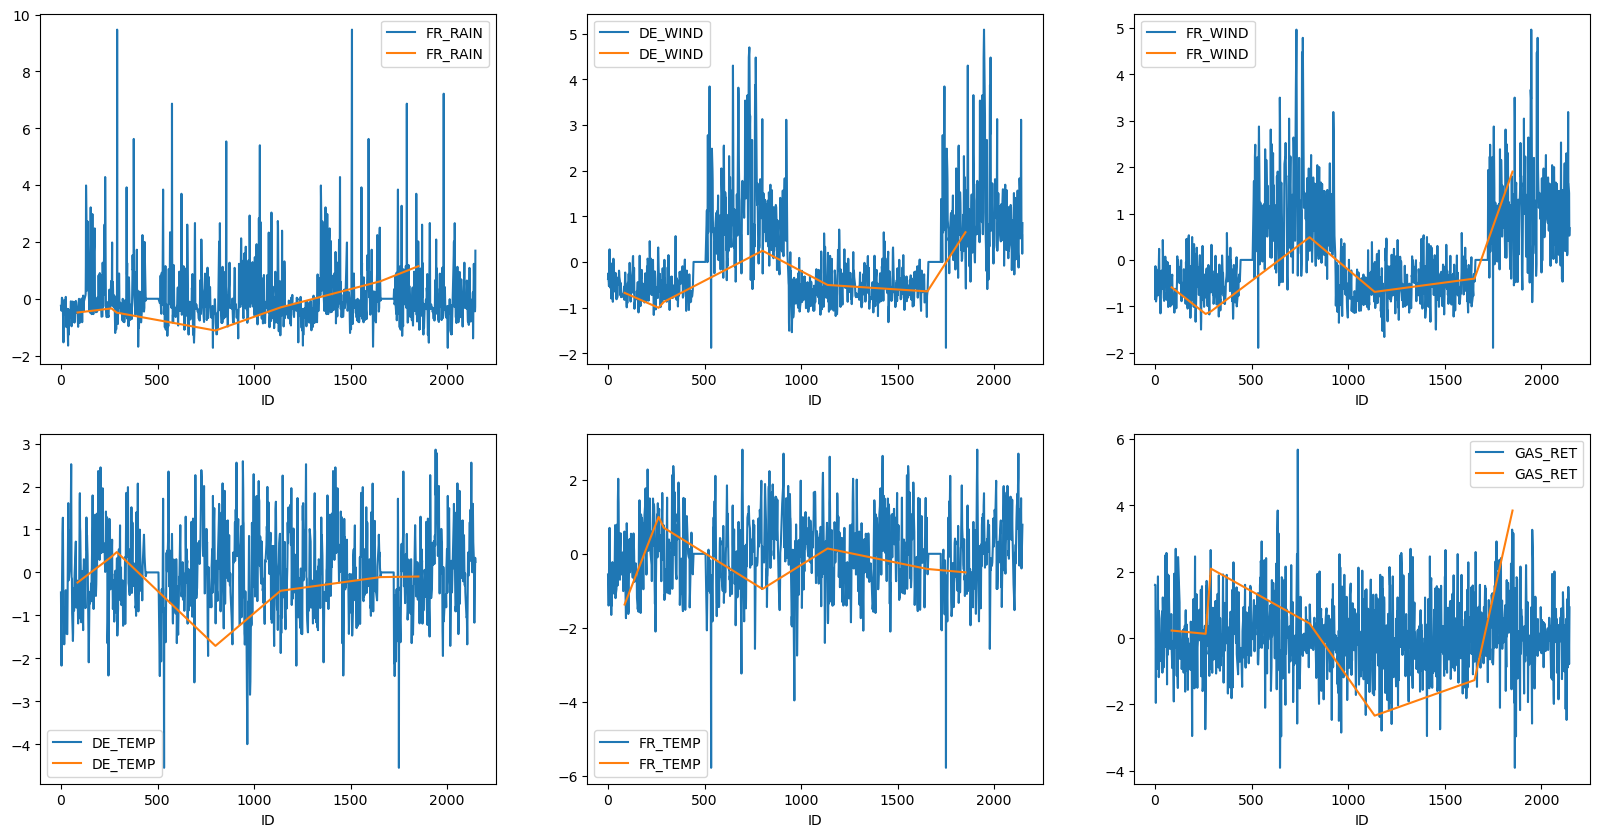

In [311]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))
ax = ax.flatten()
mask_up = f_tot["TARGET"] > 6
mask_down = f_tot["TARGET"] < 0.5
kk = -1
# Change the slice from [0:10] to [0:6]
for ii in list(f_tot.drop(columns=["COUNTRY"]).columns)[26:32]:
    kk = kk + 1
    f_tot[mask_down].sort_values(by="ID", ascending=True).plot(x="ID", y=ii, ax=ax[kk])
    f_tot[mask_up].sort_values(by="ID", ascending=True).plot(x="ID", y=ii, ax=ax[kk])




In [312]:
print((Y_test_submission_all["ID"].values == X_test["ID"].values).all())

True


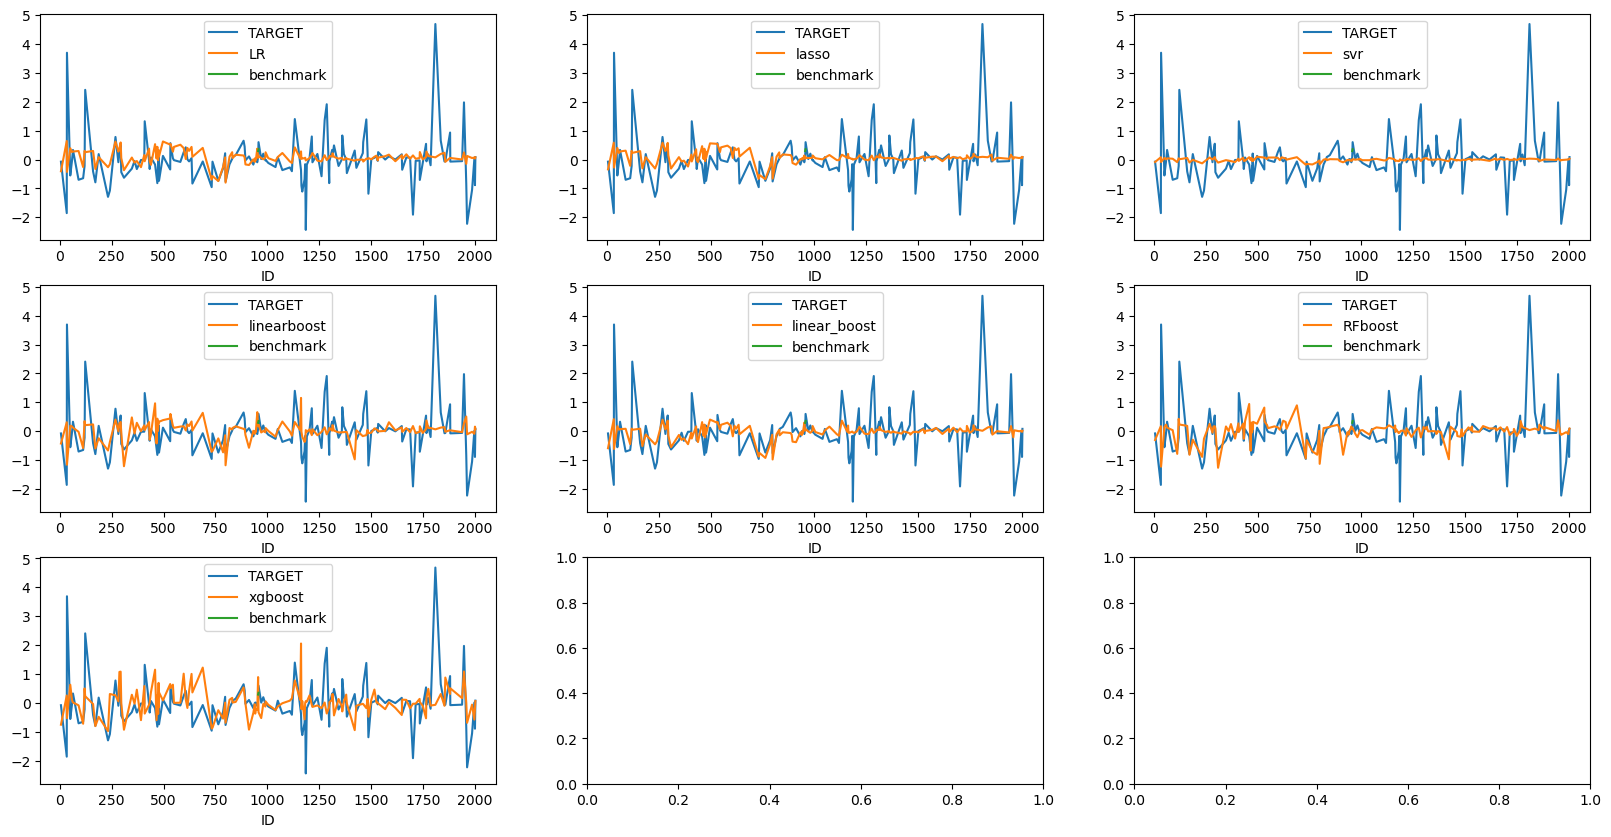

In [313]:
Y_test_submission_all["benchmark"] = Y_test_submission_origi["TARGET"]

fig, ax = plt.subplots(ncols=3,nrows=3,figsize=(20,10))
ax=ax.flatten()
ii=0
for method in  list(Y_test_submission_all.drop(columns=["benchmark","ID"]).columns):

    mask_val_set = np.isfinite(f_tot[method])
    f_tot[mask_val_set].sort_values(by="ID",ascending=True).plot(x="ID", y="TARGET", ax=ax[ii])
    f_tot[mask_val_set].sort_values(by="ID",ascending=True).plot(x="ID", y=method, ax=ax[ii])
    f_tot[mask_val_set].sort_values(by="ID",ascending=True).plot(x="ID", y="benchmark", ax=ax[ii])
    ii +=1

In [314]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau


def NN_prep(f_tot, X_test, country, criterion, residual_meth=None):
    mask_tr   = (f_tot["COUNTRY"] == country)
    mask_test = (X_test["COUNTRY"] == country)

    if country == "tot":
        mask_tr   = ~mask_tr
        mask_test = ~mask_test
    
    X_tot                                = features_selection(f_tot[mask_tr].drop(columns=["TARGET"]), feat["tot"])
    X_test_feat                          = features_selection(X_test[mask_test],feat["tot"])

    if residual_meth is not None:    
        y_tot = f_tot[mask_tr]["TARGET"] - f_tot[mask_tr][residual_meth + "train"].fillna(f_tot[residual_meth])

        if isinstance(criterion, nn.HuberLoss):
            delta = criterion.delta  # usa 1.0 se non esiste
            y_tot = y_tot.clip(-delta, delta)         # <-- CLIPPING in pandas

    else:
        y_tot = f_tot[mask_tr]["TARGET"]

    X_train, X_val, Y_train, Y_val       = train_test_split(X_tot, y_tot, test_size=0.1, random_state=0)

    scaler           = StandardScaler().fit(X_train)
    X_train          = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_val            = pd.DataFrame(scaler.transform(X_val), index=X_val.index, columns=X_val.columns)
    X_test_feat      = pd.DataFrame(scaler.transform(X_test_feat), index=X_test_feat.index, columns=X_test_feat.columns)


    x_train = torch.tensor(X_train.values, dtype=torch.float32).view(-1, len(feat["tot"]))
    y_train = torch.tensor(Y_train.to_numpy(), dtype=torch.float32).view(-1, 1)
    x_val   = torch.tensor(X_val.values, dtype=torch.float32).view(-1, len(feat["tot"]))
    y_val   = torch.tensor(Y_val.to_numpy(), dtype=torch.float32).view(-1, 1)
    # print("shape of torch tensor is: ")
    # print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

    # Setup data loaders for batch
    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    test_dataset = TensorDataset(x_val, y_val)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return test_loader, test_dataset, train_loader, train_dataset, X_test_feat, X_train, Y_train, X_val, Y_val


In [348]:
import torch.nn.functional as F
class MLPModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        # self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)
        self.fdrop_1 =  nn.Dropout(p=0.3)   # ← qui
        self.fdrop_2 =  nn.Dropout(p=0.1)   # ← qui

    def forward(self, x):
        x = F.relu(self.fc1(x))

        x = self.fdrop_1(x)

        x = F.relu(self.fc3(x))
        x = self.fdrop_2(x)

        x = F.relu(self.fc4(x))
        # x = self.fdrop(x)
        x = self.fc5(x)
        return x.squeeze(1)  #
    

def training_NN(model,test_loader, train_loader, criterion,optimizer,epochs,scheduler,verbose=False):
    early_stop_count = 0
    min_val_loss = float('inf')
    max_val_var  = 0
    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            x_batch, y_batch = batch
            y_batch = y_batch.squeeze(-1)  #  for dimension compatibility

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss    = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for batch in test_loader:
                x_batch, y_batch = batch
                y_batch = y_batch.squeeze(-1)  # for dimension compatibility

                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
                    
                val_losses.append(loss.item())

        val_loss = np.mean(val_losses)
        scheduler.step(val_loss)

        
        if len(y_batch) > 5:
            if val_loss < min_val_loss or torch.var(outputs) > max_val_var:
                min_val_loss = val_loss
                max_val_var = torch.var(outputs)
                early_stop_count = 0
            else:
                early_stop_count += 1

            if early_stop_count >= 30:
                print("Early stopping!")
                break
            if epoch%5 == 0 and verbose:
                print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.8f}")
                print("Batch output variance:", torch.var(outputs))
                print("Batch labels variance:", torch.var(y_batch))

    
    return model





def pred_NN_learning(model, Y_test_submission_all, df, X_train, Y_train, X_val, Y_val, X_test_feat, method, alpha_boost, boosting_met ):
    model.eval()
    with torch.no_grad():
        x_train = torch.tensor(X_train.values, dtype=torch.float32).view(-1, len(feat["tot"]))
        x_val   = torch.tensor(X_val.values, dtype=torch.float32).view(-1, len(feat["tot"]))
        x_test  = torch.tensor(X_test_feat.values, dtype=torch.float32).view(-1, len(feat["tot"]))

        y_pred_train = model(x_train).numpy()  
        y_pred_test  = model(x_val).numpy() 

        Y_test       = model(x_test).numpy()

        if not(boosting_met == None):
            y_pred_test  = df.loc[X_val.index, boosting_met].fillna(df.loc[X_val.index, boosting_met+"train"])   + alpha_boost * y_pred_test 
            y_pred_train = df.loc[X_train.index, boosting_met+"train"].fillna(df.loc[X_train.index, boosting_met]) + alpha_boost * y_pred_train
            Y_test       = Y_test_submission_all.loc[X_test_feat.index, boosting_met] + alpha_boost * Y_test


        df.loc[X_val.index, method]           = y_pred_test
        df.loc[X_train.index, method+"train"] = y_pred_train

        Y_test_submission_all.loc[X_test_feat.index, method] = Y_test
   
    return df


def plot_learning(df,method):
        
    mask_tr    =  np.isfinite(df[method+"train"])
    mask_val   =  np.isfinite(df[method])
    fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,4))
    ax[1].scatter(df[mask_tr]["TARGET"], df[mask_tr][method+"train"], s=5, alpha=0.5)
    ax[1].set_xlabel("True y (train)")
    ax[1].set_ylabel("Predicted y")
    ax[1].set_title("Train fit "+method)
    ax[1].plot([df[mask_tr]["TARGET"].min(), df[mask_tr]["TARGET"].max()], [df[mask_tr]["TARGET"].min(), df[mask_tr]["TARGET"].max()], 'r--')
    ax[1].set_xlim([-3,3])
    ax[1].set_ylim([df[mask_tr][method+"train"].min(),df[mask_tr][method+"train"].max()])

    ax[0].scatter(df[mask_val]["TARGET"], df[mask_val][method], s=5, alpha=0.5)
    ax[0].plot([df[mask_val]["TARGET"].min(), df[mask_val]["TARGET"].max()], [df[mask_val]["TARGET"].min(), df[mask_val]["TARGET"].max()], 'r--')

    ax[0].set_xlabel("True y (test)")
    ax[0].set_ylabel("Predicted y")
    ax[0].set_title("Test fit "+method)
    # ax[0].plot([df[mask_val]["TARGET"].min(), df[mask_val]["TARGET"].max()], [df[mask_val]["TARGET"].min(), df[mask_val]["TARGET"].max()], 'r--')

    ax[0].set_xlim([-2,2])
    ax[0].set_ylim([df[mask_val][method].min(),df[mask_val][method].max()])
    
    return 

In [349]:
epochs = 100
starting_methods = ["xgboost", "RFboost"]
alpha_boost = 0.1
old_spear_corr = 0
verbose = False
ori_methods = ["NN-Hub_multiple"]
methods     = ori_methods

for initial_pred in starting_methods:
    if not(initial_pred == None):
        for ii in range(len(ori_methods)):
            methods[ii] = initial_pred+ori_methods[ii]

    # for method, criterion in zip(["NN-Hub","NN"], [nn.HuberLoss(), nn.MSELoss()]):
    for method, criterion in zip(methods, [nn.HuberLoss()]):
        boosting_met    = initial_pred
        criterion_boost = nn.MSELoss() 
        for iter_boost in range(5):
            for country in ["FR","DE"]:
                
                test_loader, test_dataset, train_loader, train_dataset, X_test_feat, X_train, Y_train, X_val, Y_val =  NN_prep(f_tot, X_test, country, criterion_boost, residual_meth=boosting_met)
                x_train = torch.tensor(X_train.values, dtype=torch.float32).view(-1, len(feat["tot"]))

                model = MLPModel(input_dim=x_train.shape[1])
                
                optimizer = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay = 1e-2)
                scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.8, patience=100)
                model = training_NN(model,test_loader, train_loader, criterion, optimizer,epochs,scheduler,verbose)

                f_tot = pred_NN_learning(model, Y_test_submission_all, f_tot, X_train, Y_train, X_val, Y_val, X_test_feat, method, alpha_boost, boosting_met )

            boosting_met    = method
            criterion_boost = criterion

            metric = error_metric(f_tot, metric,method)
            print(metric.spear_corr[method], metric.spear_corr_tr[method])
            if old_spear_corr > metric.spear_corr[method]:
                break
            old_spear_corr = metric.spear_corr[method]

0.8018895134793393 0.8003511939981769
0.8025744229031182 0.800491180856999
Early stopping!
0.8021247877088816 0.8007093636840796
Early stopping!
0.619109321478071 0.5490053896499058


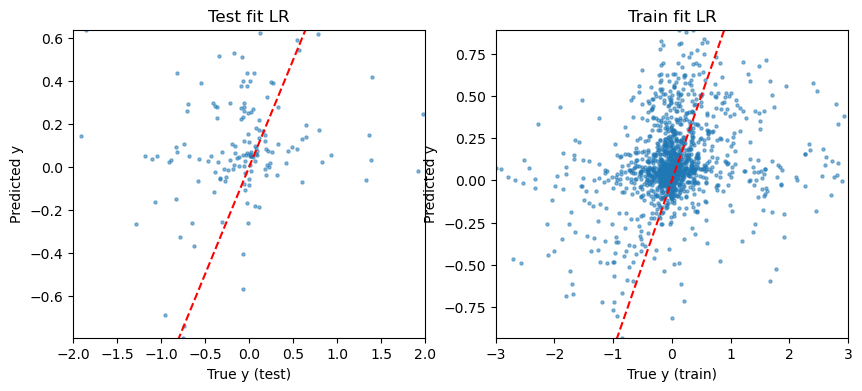

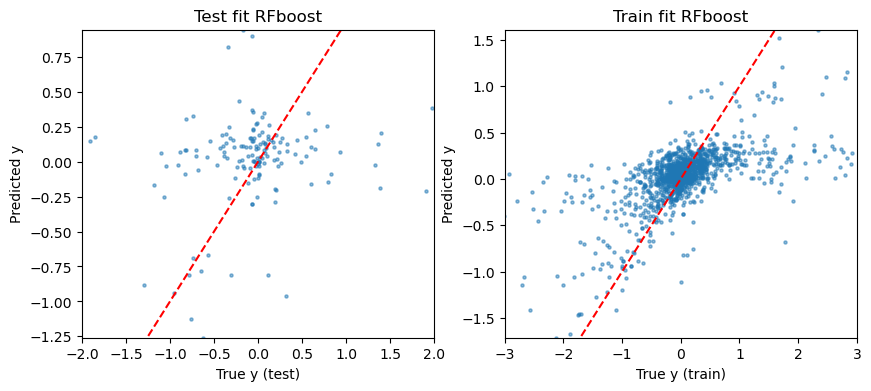

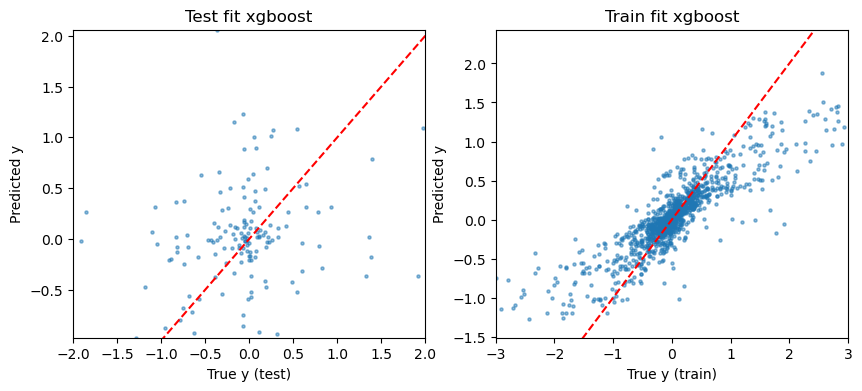

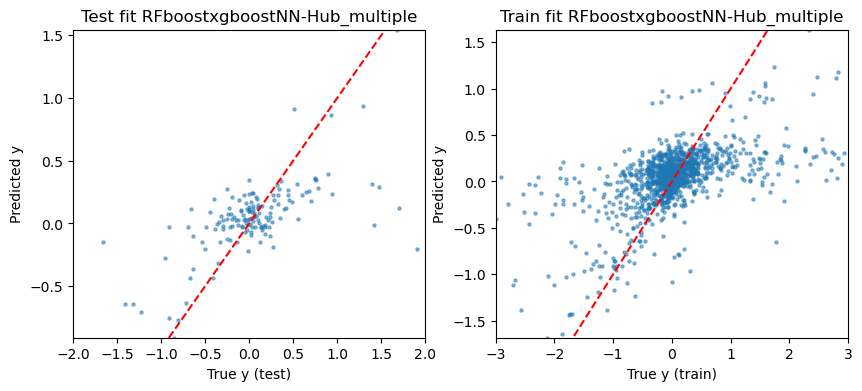

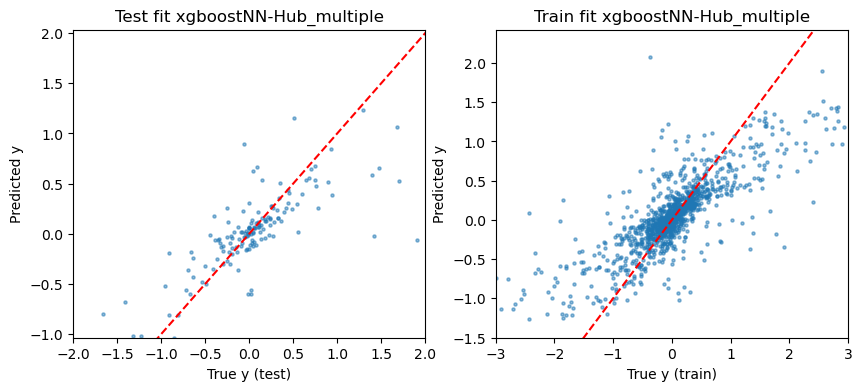

In [355]:
plot_learning(f_tot,"LR")
# plot_learning(f_tot,"linearboost")
# plot_learning(f_tot,"linear_boost")
# plot_learning(f_tot,"lasso")
# plot_learning(f_tot,"svr")
# plot_learning(f_tot,"NN")
# plot_learning(f_tot,"NN-Hub")
plot_learning(f_tot,"RFboost")
plot_learning(f_tot,"xgboost")
plot_learning(f_tot,list(metric.rmse.keys())[-1])
plot_learning(f_tot,list(metric.rmse.keys())[-2])



In [344]:
print("training set")

for mm in metric.rmse.keys():
    print(metric.rmse_tr[mm], metric.spear_corr_tr[mm], mm)

print("-----------------------------------------")

print("validation set")

for mm in metric.rmse.keys():
    print(metric.rmse[mm], metric.spear_corr[mm], mm)

training set
1.027132709259684 0.274325135215802 LR
1.0284978150876647 0.2800236191484702 lasso
1.0506118479754785 0.30538646151254095 svr
0.9391723849191803 0.538102799672036 linearboost
1.0358594869954454 0.27018149978917777 linear_boost
0.9376966199849982 0.6146853160450645 RFboost
0.672613999570481 0.8711818378282846 xgboost
0.715371107284483 0.802422426136194 xgboostNN-Hub_multiple
-----------------------------------------
validation set
0.8394995062278418 0.1952702991202372 LR
0.8337374712630751 0.1907617556307413 lasso
0.8132769943544892 0.2217325041239114 svr
0.878885588924237 0.1252528104329601 linearboost
0.8289644205865805 0.20368438801366046 linear_boost
0.8708365250014646 0.1300891078583267 RFboost
0.89560831284591 0.16302558646362625 xgboost
0.5362764689500895 0.806886377559018 xgboostNN-Hub_multiple


In [354]:
Y_test_submission_G = Y_test_submission_all[['ID']].copy()
Y_test_submission_G["TARGET"] = Y_test_submission_all["xgboostNN-Hub_multiple"]
Y_test_submission_G.to_csv('benchmark_qrt_G.csv', index=False)
Y_test_submission_G.head()

,ID,TARGET
0,1115,-0.176738
1,1202,-0.127759
2,1194,-0.137434
3,1084,0.052565
4,1135,0.049279


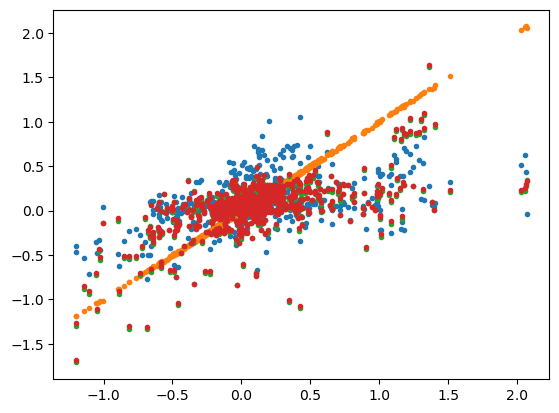

In [353]:
plt.plot(Y_test_submission_all["xgboostNN-Hub_multiple"], Y_test_submission_all["LR"],".")
plt.plot(Y_test_submission_all["xgboostNN-Hub_multiple"], Y_test_submission_all["xgboost"],".")
plt.plot(Y_test_submission_all["xgboostNN-Hub_multiple"], Y_test_submission_all["RFboost"],".")
plt.plot(Y_test_submission_all["xgboostNN-Hub_multiple"], Y_test_submission_all["RFboostxgboostNN-Hub_multiple"],".")

In [346]:
Y_test_submission_all["xgboostNN-Hub_multiple"].iloc[0:5]

0   -0.172854
1   -0.123874
2   -0.133547
3     0.05645
4    0.053163
Name: xgboostNN-Hub_multiple, dtype: object